# Third Approach- Dual-Path CNN Model

# Step 1: Install Dependencies & Import Libraries



In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Step 2: Define Paths and Load Data

In [ ]:
!unzip /content/ISBI2016_ISIC_Part3B_Training_Data.zip
! unzip /content/ISBI2016_ISIC_Part3B_Test_Data.zip

Archive:  /content/ISBI2016_ISIC_Part3B_Training_Data.zip
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000000.jpg  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000000_Segmentation.png  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000001.jpg  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000001_Segmentation.png  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000002.jpg  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000002_Segmentation.png  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000004.jpg  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000004_Segmentation.png  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000006.jpg  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000006_Segmentation.png  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000007.jpg  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000007_Segmentation.png  
 extracting: ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000008

In [ ]:
# Define paths to dataset and CSV
DATASET_PATH = '/content/ISBI2016_ISIC_Part3B_Training_Data'
CSV_PATH = '/content/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv'

# Function to load images and masks
def load_images_and_masks(data_path, labels_df, img_size=(512, 512), max_images=60):
    images = []
    masks = []
    labels = []
    if max_images is not None:
        labels_df = labels_df.iloc[:max_images]
    for _, row in labels_df.iterrows():
        img_path = os.path.join(data_path, f"{row['image_id']}.jpg")
        mask_path = os.path.join(data_path, f"{row['image_id']}_Segmentation.png")
        label = row['label']
        if os.path.exists(img_path) and os.path.exists(mask_path):
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img) / 255.0
            mask = load_img(mask_path, color_mode='grayscale', target_size=img_size)
            mask = img_to_array(mask) / 255.0
            images.append(img)
            masks.append(mask)
            labels.append(label)
        else:
            print(f"Warning: Image or mask not found for {row['image_id']}")
    return np.array(images), np.array(masks), np.array(labels)

# Load the CSV file and encode labels
labels_df = pd.read_csv(CSV_PATH, header=None)
labels_df.columns = ['image_id', 'label']
label_encoder = LabelEncoder()
labels_df['label'] = label_encoder.fit_transform(labels_df['label'])

# Load images and masks
X_img, X_mask, y = load_images_and_masks(DATASET_PATH, labels_df, max_images=5000)



# Step 3: Perform Data Exploration

Label Distribution

In [ ]:
# Show basic dataset statistics
print("Dataset Info:")
print(labels_df.describe())

# Check label distribution
label_counts = labels_df['label'].value_counts()
print("\nLabel Distribution:")
print(label_counts)


Dataset Info:
            label
count  900.000000
mean     0.192222
std      0.394266
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

Label Distribution:
label
0    727
1    173
Name: count, dtype: int64


Visualize Sample Images from Each Class

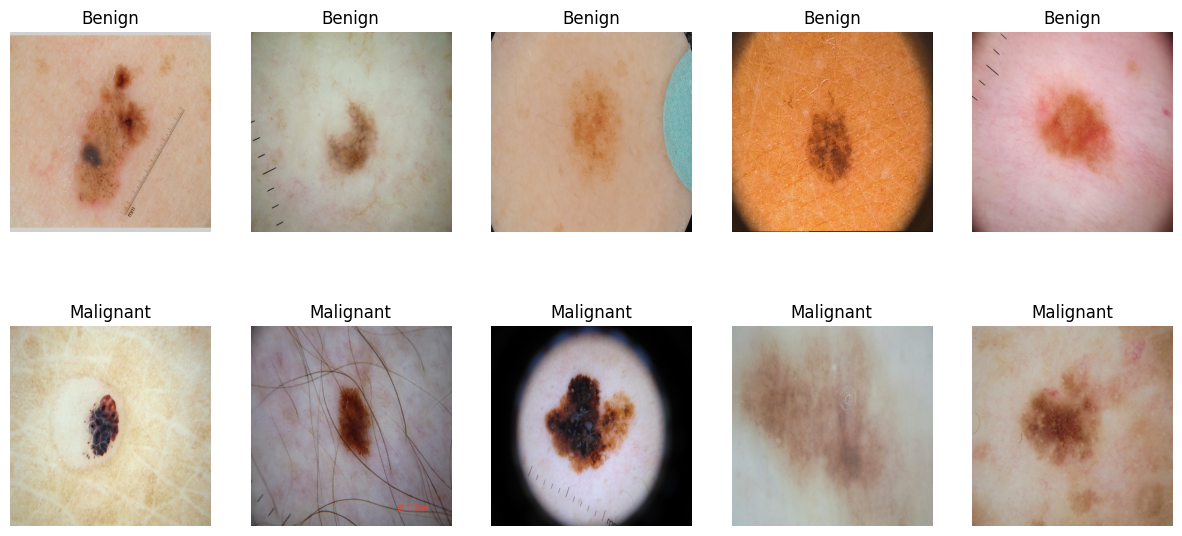

In [ ]:
# Visualize a few images from each class
fig, ax = plt.subplots(2, 5, figsize=(15, 7))
ax = ax.ravel()

benign_images = labels_df[labels_df['label'] == 0].sample(5)  # Random benign samples
malignant_images = labels_df[labels_df['label'] == 1].sample(5)  # Random malignant samples

# Load and display sample images
for i, row in enumerate(benign_images.iterrows()):
    img_path = os.path.join(DATASET_PATH, f"{row[1]['image_id']}.jpg")
    img = load_img(img_path, target_size=(512, 512))
    img = img_to_array(img) / 255.0
    ax[i].imshow(img)
    ax[i].set_title('Benign')
    ax[i].axis('off')

for i, row in enumerate(malignant_images.iterrows(), 5):
    img_path = os.path.join(DATASET_PATH, f"{row[1]['image_id']}.jpg")
    img = load_img(img_path, target_size=(512, 512))
    img = img_to_array(img) / 255.0
    ax[i].imshow(img)
    ax[i].set_title('Malignant')
    ax[i].axis('off')

plt.show()


Check for Missing or Corrupted Data

In [ ]:
# Check for missing data or corrupted images
missing_data = labels_df.isnull().sum()
print("\nMissing Data:")
print(missing_data)



Missing Data:
image_id    0
label       0
dtype: int64


Visualize a Sample Image and its Segmentation Mask

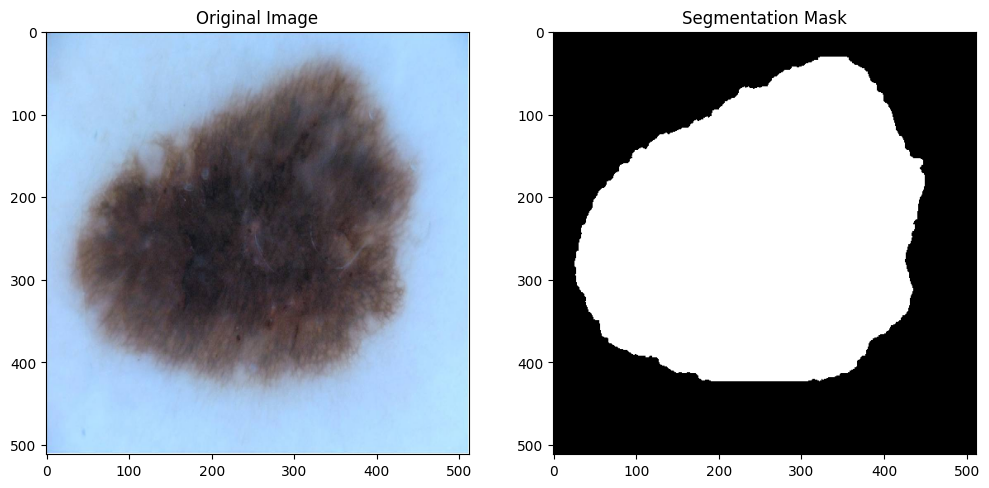

In [ ]:
# Visualize the first image and its corresponding segmentation mask
first_image_id = labels_df['image_id'].iloc[0]
first_img_path = os.path.join(DATASET_PATH, f"{first_image_id}.jpg")
first_mask_path = os.path.join(DATASET_PATH, f"{first_image_id}_Segmentation.png")

first_img = load_img(first_img_path, target_size=(512, 512))
first_mask = load_img(first_mask_path, color_mode='grayscale', target_size=(512, 512))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(first_img)
ax[0].set_title('Original Image')
ax[1].imshow(first_mask, cmap='gray')
ax[1].set_title('Segmentation Mask')
plt.show()


# Step 4: Define CNN Model

In [ ]:
def create_dual_path_cnn(input_shape):
    input_orig = Input(shape=input_shape, name='original_input')
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_orig)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    input_shape_mask = (input_shape[0], input_shape[1], 1)
    input_seg = Input(shape=input_shape_mask, name='segmentation_input')
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_seg)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    combined = concatenate([x1, x2])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(combined)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_orig, input_seg], outputs=output)
    return model


# Step 5: Train Model with K-Fold Cross Validation

In [ ]:
# Prepare for k-folds cross-validation
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
train_acc = []
val_acc = []

# Training loop for k-folds cross-validation
for train_index, val_index in kf.split(X_img):
    X_img_train, X_img_val = X_img[train_index], X_img[val_index]
    X_mask_train, X_mask_val = X_mask[train_index], X_mask[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_dual_path_cnn((512, 512, 3))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    history = model.fit(
        [X_img_train, X_mask_train], y_train,
        validation_data=([X_img_val, X_mask_val], y_val),
        epochs=15,
        batch_size=3,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5802 - loss: 5.9653 - val_accuracy: 0.8000 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8128 - loss: 0.9064 - val_accuracy: 0.8000 - val_loss: 0.6800 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7417 - loss: 0.6715 - val_accuracy: 0.8000 - val_loss: 0.5663 - learning_rate: 0.0010
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8183 - loss: 0.4856 - val_accuracy: 0.8000 - val_loss: 0.4401 - learning_rate: 0.0010
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8093 - loss: 0.5048 - val_accuracy: 0.8000 - val_loss: 0.4757 - learning_rate: 0.0010
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7748 - loss: 0.4694 - val_accuracy: 0.8000 - val_loss: 0.4486 - learning_rate: 0.0010
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7989 - loss: 0.4909 - val_acc

# Step 6: Evaluate Model and Plot Training Progress

Epoch	Average Training Accuracy	Average Validation Accuracy
1	0.6917			0.8000
2	0.8000			0.8000
3	0.7917			0.8000
4	0.8000			0.8000
5	0.8500			0.8000
6	0.8667			0.7167
7	0.8917			0.7667
8	0.9250			0.7500
9	0.9333			0.7667
10	0.9333			0.7500
11	0.9250			0.7833
12	0.9167			0.7833
13	0.9333			0.7500
14	0.9333			0.7667


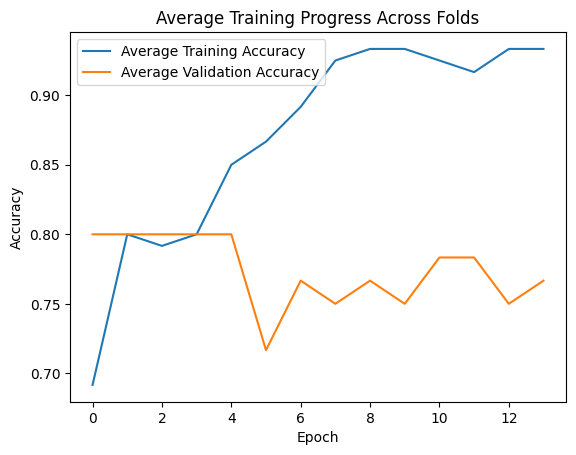

In [ ]:
# Truncate each list in train_acc and val_acc to the minimum length found across all folds
min_length = min(len(acc) for acc in train_acc)
train_acc_uniform = [acc[:min_length] for acc in train_acc]
val_acc_uniform = [acc[:min_length] for acc in val_acc]

# Now calculate the average accuracy safely
average_train_acc = np.mean(train_acc_uniform, axis=0)
average_val_acc = np.mean(val_acc_uniform, axis=0)

# Print the average accuracies for each epoch
print("Epoch\tAverage Training Accuracy\tAverage Validation Accuracy")
for epoch in range(len(average_train_acc)):
    print(f"{epoch + 1}\t{average_train_acc[epoch]:.4f}\t\t\t{average_val_acc[epoch]:.4f}")

# Plot the results
plt.plot(average_train_acc, label='Average Training Accuracy')
plt.plot(average_val_acc, label='Average Validation Accuracy')
plt.title('Average Training Progress Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


# Step 7: Save the Model

In [ ]:
# Save the trained model
model.save('/content/my_model.h5')  # Saving the model to the Colab local storage


# Step 8: Evaluate Model on Test Set

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, accuracy_score


# Define path to the test dataset and labels
TEST_DATA_PATH = '/content/ISBI2016_ISIC_Part3B_Test_Data'
TEST_CSV_PATH = '/content/ISBI2016_ISIC_Part3B_Test_GroundTruth.csv'


def load_test_images(data_path, img_size=(512, 512)):
    original_images = []
    processed_images = []  # This could be any other transformation of the images
    image_ids = []
    for img_name in os.listdir(data_path):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(data_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0

            # Assuming we also prepare a processed version of the image
            # For example, converting to grayscale (adjust according to actual needs)
            processed_img = tf.image.rgb_to_grayscale(img_array)

            original_images.append(img_array)
            processed_images.append(processed_img)
            image_ids.append(img_name.split('.')[0])

    return np.array(original_images), np.array(processed_images), image_ids

# Load the CSV file and specify column names explicitly if not included
labels_df = pd.read_csv(TEST_CSV_PATH, header=None, names=['image_id', 'label'])

# Check if the DataFrame has the expected columns
print("DataFrame Columns:", labels_df.columns)

# Set 'image_id' as the index for easier access
labels_df.set_index('image_id', inplace=True)

# Load test images and the corresponding processed versions
X_test_original, X_test_processed, test_image_ids = load_test_images(TEST_DATA_PATH)

# Check the retrieved image IDs to ensure they are present in the labels DataFrame
print("Test Image IDs:", test_image_ids[:5])  # Print first few IDs for checking
print("DataFrame Index Sample:", labels_df.index[:5])  # Print first few index entries

# Get corresponding labels for the loaded images using the correct index
try:
    y_test = labels_df.loc[test_image_ids, 'label'].values
except KeyError as e:
    print("Error retrieving labels:", e)
    print("Check that your test image IDs match those in the labels DataFrame.")

# Predict on test data using both inputs
y_pred = model.predict([X_test_original, X_test_processed])
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))
print("Accuracy:", accuracy_score(y_test, y_pred_classes))



DataFrame Columns: Index(['image_id', 'label'], dtype='object')
Test Image IDs: ['ISIC_0010498', 'ISIC_0000200', 'ISIC_0005000', 'ISIC_0010234', 'ISIC_0000392']
DataFrame Index Sample: Index(['ISIC_0000003', 'ISIC_0000012', 'ISIC_0000013', 'ISIC_0000014',
       'ISIC_0000015'],
      dtype='object', name='image_id')
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 811ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       304
         1.0       0.00      0.00      0.00        75

    accuracy                           0.80       379
   macro avg       0.40      0.50      0.45       379
weighted avg       0.64      0.80      0.71       379

Accuracy: 0.8021108179419525


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


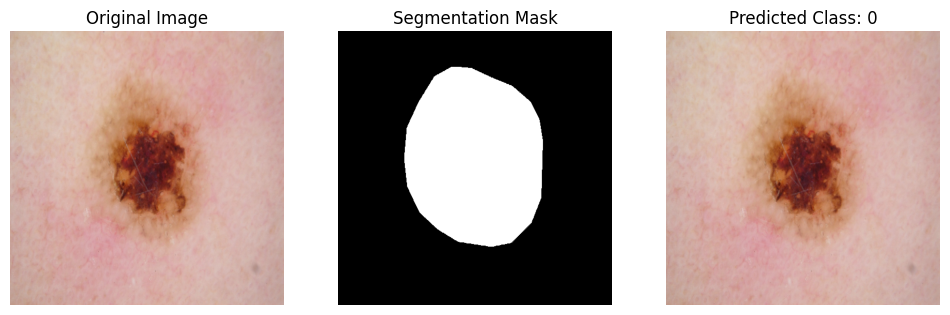

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define paths
test_image_path = '/content/ISBI2016_ISIC_Part3B_Test_Data/ISIC_0010498.jpg'  # Example image
test_mask_path = '/content/ISBI2016_ISIC_Part3B_Test_Data/ISIC_0010498_Segmentation.png'  # Example mask

# Load and preprocess the image
def preprocess_image(img_path, img_size=(512, 512)):
    img = load_img(img_path, target_size=img_size)
    img = img_to_array(img) / 255.0
    return img

# Load and preprocess the mask
def preprocess_mask(mask_path, img_size=(512, 512)):
    mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
    mask = img_to_array(mask) / 255.0
    return mask

# Load the images
img = preprocess_image(test_image_path)
mask = preprocess_mask(test_mask_path)

# Load the model
model = load_model('/content/my_model.h5')

# Predict the class
img_input = np.expand_dims(img, axis=0)  # Model expects a batch of images
mask_input = np.expand_dims(mask, axis=0)  # Model expects a batch of masks
prediction = model.predict([img_input, mask_input])
predicted_class = np.argmax(prediction, axis=1)[0]  # Assuming the model outputs logits for each class

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')

plt.show()


0: Usually represents benign lesions.